In [1]:
# ============================================================================
# STEP 1: Setup & Imports
# ============================================================================
import sys
from pathlib import Path

import torch
import torch.nn.functional as F
import numpy as np
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pandas as pd

# Import from your codebase
from CLAPWrapper import CLAPWrapper
from datasets.esc50 import ESC50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

Device: cpu


In [2]:
# ============================================================================
# STEP 2.1: Load Dataset & Model
# ============================================================================
print("\n" + "="*70)
print("LOADING ESC50 & CLAP MODEL")
print("="*70)

root_path = "./data"
dataset = ESC50(root=root_path, download=True)
print(f"✅ Dataset: {len(dataset)} samples, {len(dataset.classes)} classes")


LOADING ESC50 & CLAP MODEL
Loading audio files


0it [00:00, ?it/s]

2000it [00:00, 12453.23it/s]

✅ Dataset: 2000 samples, 50 classes


Explore the dataset.

In [3]:
dataset.df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [4]:
# Path, label, one-hot encoding of label
dataset[0]

('./data/ESC-50-master/audio/1-100032-A-0.wav',
 'dog',
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

In [5]:
from IPython.display import Audio

Audio(filename=dataset[0][0])

Preparing the text prompts.

In [6]:
# Prepare text prompts
prompt = 'this is the sound of '
text_labels = [prompt + x for x in dataset.classes]

In [7]:
# ============================================================================
# STEP 2.2: Load the Model
# ============================================================================

# Load CLAP
wrapper = CLAPWrapper(version='2023', use_cuda=torch.cuda.is_available())
clap_model = wrapper.clap
clap_model.eval()

print("✅ CLAP model loaded")

✅ CLAP model loaded


In [8]:
# ============================================================================
# STEP 2.3: Model Summary
# ============================================================================
print("\n" + "="*70)
print("MODEL SUMMARY")
print("="*70, '\n\n')

print("=" * 25 + " Text Encoder " + "=" * 25)
print(f"   Text model:              {wrapper.args.text_model}")
print(f"   Text length:             {wrapper.args.text_len}")
print(f"   Transformer embed dim:   {wrapper.args.transformer_embed_dim}")
print(f"   Freeze text weights:     {wrapper.args.freeze_text_encoder_weights}")

print('\n\n' + "=" * 25 + " Audio Encoder " + "=" * 25)

print(f"   Audio encoder:           {wrapper.args.audioenc_name}")
print(f"   Audio sample rate:       {wrapper.args.sampling_rate} Hz")
print(f"   Audio duration:          {wrapper.args.duration} s")
print(f"   Mel bins:                {wrapper.args.mel_bins}")
print(f"   FFT size:                {wrapper.args.n_fft}")
print(f"   Hop size:                {wrapper.args.hop_size}")
print(f"   Window size:             {wrapper.args.window_size}")
print(f"   Freq range:              {wrapper.args.fmin}–{wrapper.args.fmax} Hz")

print('\n\n' + "=" * 25 + " CLAP Params " + "=" * 25)

print(f"   Output embedding dim:    {wrapper.args.out_emb}")
print(f"   Projection dim (d_proj): {wrapper.args.d_proj}")
print(f"   Temperature:             {wrapper.args.temperature}")
print(f"   Num classes:             {wrapper.args.num_classes}")
print(f"   Batch size:              {wrapper.args.batch_size}")
print(f"   Demo mode:               {wrapper.args.demo}")


MODEL SUMMARY


========================= Text Encoder =========================
   Text model:              gpt2
   Text length:             77
   Transformer embed dim:   768
   Freeze text weights:     True


========================= Audio Encoder =========================
   Audio encoder:           HTSAT
   Audio sample rate:       44100 Hz
   Audio duration:          7 s
   Mel bins:                64
   FFT size:                1024
   Hop size:                320
   Window size:             1024
   Freq range:              50–8000 Hz


========================= CLAP Params =========================
   Output embedding dim:    768
   Projection dim (d_proj): 1024
   Temperature:             0.003
   Num classes:             527
   Batch size:              1024
   Demo mode:               False


In [9]:
# ============================================================================
# STEP 3: Extract Attention Heads Architecture Info
# ============================================================================
print("\n" + "="*70)
print("ANALYZING HTSAT ARCHITECTURE")
print("="*70)

# Get audio encoder (HTSAT)
audio_encoder = clap_model.audio_encoder.base.htsat

# Inspect architecture
print(f"\n📐 HTSAT Architecture:")
print(f"   Number of layers: {audio_encoder.num_layers}")
print(f"   Depths per layer: {audio_encoder.depths}")
print(f"   Number of heads per layer: {audio_encoder.num_heads}")
print(f"   Embed dimensions: {audio_encoder.embed_dim}")
print(f"   Window size: {audio_encoder.window_size}")

# Calculate total number of attention heads
total_heads = 0
head_info = []
for layer_idx, (depth, n_heads) in enumerate(zip(audio_encoder.depths, audio_encoder.num_heads)):
    layer_heads = depth * n_heads
    total_heads += layer_heads
    head_info.append({
        'layer': layer_idx,
        'depth': depth,
        'n_heads': n_heads,
        'total_heads_in_layer': layer_heads
    })
    print(f"   Layer {layer_idx}: {depth} blocks × {n_heads} heads = {layer_heads} total heads")

print(f"\n   🎯 TOTAL ATTENTION HEADS: {total_heads}")

# Store for later
head_info_df = pd.DataFrame(head_info)


ANALYZING HTSAT ARCHITECTURE

📐 HTSAT Architecture:
   Number of layers: 4
   Depths per layer: [2, 2, 6, 2]
   Number of heads per layer: [4, 8, 16, 32]
   Embed dimensions: 96
   Window size: 8
   Layer 0: 2 blocks × 4 heads = 8 total heads
   Layer 1: 2 blocks × 8 heads = 16 total heads
   Layer 2: 6 blocks × 16 heads = 96 total heads
   Layer 3: 2 blocks × 32 heads = 64 total heads

   🎯 TOTAL ATTENTION HEADS: 184


In [10]:
# ============================================================================
# STEP 4: Hook Registration - Extract Head Representations
# ============================================================================
print("\n" + "="*70)
print("SETTING UP ATTENTION HEAD EXTRACTION")
print("="*70)

class HeadExtractor:
    """Extract attention head outputs from HTSAT"""
    
    def __init__(self, model):
        self.model = model
        self.head_outputs = defaultdict(list)
        self.attention_weights = defaultdict(list)
        self.hooks = []
        
    def _get_hook(self, layer_idx, block_idx):
        """Create hook function for specific layer and block"""
        def hook(module, input, output):
            # output is tuple: (x, attn)
            # x shape: [B, N, C] where N = num_patches
            # attn shape: [B, num_heads, N, N]
            x, attn = output
            
            # Store the output AFTER attention (this is what goes to residual)
            key = f"L{layer_idx}_B{block_idx}"
            self.head_outputs[key].append(x.detach().cpu())
            self.attention_weights[key].append(attn.detach().cpu())
            
        return hook
    
    def register_hooks(self):
        """Register forward hooks on all SwinTransformerBlocks"""
        print("\n📍 Registering hooks...")
        
        for layer_idx, layer in enumerate(self.model.layers):
            for block_idx, block in enumerate(layer.blocks):
                hook = block.register_forward_hook(
                    self._get_hook(layer_idx, block_idx)
                )
                self.hooks.append(hook)
                
        print(f"   ✅ Registered {len(self.hooks)} hooks")
        
    def remove_hooks(self):
        """Remove all hooks"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        
    def clear_cache(self):
        """Clear stored outputs"""
        self.head_outputs.clear()
        self.attention_weights.clear()
        
    def get_head_representations(self):
        """Return collected head representations"""
        return self.head_outputs, self.attention_weights

# Initialize extractor
extractor = HeadExtractor(audio_encoder)
extractor.register_hooks()


SETTING UP ATTENTION HEAD EXTRACTION

📍 Registering hooks...
   ✅ Registered 12 hooks


In [11]:
dataset[0]

('./data/ESC-50-master/audio/1-100032-A-0.wav',
 'dog',
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

In [12]:
# ============================================================================
# STEP 5: Extract Head Representations on Sample Data
# ============================================================================
print("\n" + "="*70)
print("EXTRACTING HEAD REPRESENTATIONS")
print("="*70)

# Use subset for initial analysis
n_samples = 200  # Stratified across classes
samples_per_class = n_samples // len(dataset.classes)

print(f"\n📊 Extracting from {n_samples} samples ({samples_per_class} per class)...")

# Collect audio samples stratified by class
class_samples = defaultdict(list)
for idx in range(len(dataset)):
    audio_path, class_name, one_hot_target = dataset[idx]
    class_idx = torch.argmax(one_hot_target).item()
    print(f"Sample {idx}: {class_name} (class {class_idx}) -> {audio_path}")
    
    # Se abbiamo meno samples per questa classe di sample_per_class
    if len(class_samples[class_idx]) < samples_per_class:
        # allora aggiungiamo questo sample 
        class_samples[class_idx].append((audio_path, class_idx))
    
    # Se abbiamo che i samples per ogni classe sono piu di sample_per_class
    if all(len(samples) >= samples_per_class for samples in class_samples.values()):
        # ci fermiamo
        break

# Qui abbiamo dentro class_samples
## keys := indice della classe 
## values := (path audio, indice della classe)

# Flatten to list (creiamo una lista di tuple (path audio, indice della classe))
sample_list = []
for class_idx, samples in class_samples.items():
    sample_list.extend(samples)

print(f"   Collected {len(sample_list)} samples")

# Puliamo il cache dell'extractor
extractor.clear_cache()
all_labels = []

# Extract representations
for audio_path, label in tqdm(sample_list, desc="Extracting heads"):
    # Preprocess audio
    audio_tensor = wrapper.load_audio_into_tensor(
        audio_path, wrapper.args.duration, resample=True
    )
    audio_tensor = audio_tensor.reshape(1, -1).to(device)
    
    # Forward pass (hooks will capture head outputs)
    with torch.no_grad():
        _ = audio_encoder(audio_tensor)
    
    all_labels.append(label)

# Get collected representations
head_outputs, attention_weights = extractor.get_head_representations()

print(f"\n✅ Extracted representations from {len(head_outputs)} blocks")
print(f"   Example block shape: {head_outputs[list(head_outputs.keys())[0]][0].shape}")
print(f"   Labels shape: {len(all_labels)}")


EXTRACTING HEAD REPRESENTATIONS

📊 Extracting from 200 samples (4 per class)...
Sample 0: dog (class 18) -> ./data/ESC-50-master/audio/1-100032-A-0.wav
Sample 1: chirping birds (class 7) -> ./data/ESC-50-master/audio/1-100038-A-14.wav
Sample 2: vacuum cleaner (class 46) -> ./data/ESC-50-master/audio/1-100210-A-36.wav
Sample 3: vacuum cleaner (class 46) -> ./data/ESC-50-master/audio/1-100210-B-36.wav
Sample 4: thunderstorm (class 43) -> ./data/ESC-50-master/audio/1-101296-A-19.wav
Sample 5: thunderstorm (class 43) -> ./data/ESC-50-master/audio/1-101296-B-19.wav
Sample 6: door wood knock (class 20) -> ./data/ESC-50-master/audio/1-101336-A-30.wav
Sample 7: can opening (class 3) -> ./data/ESC-50-master/audio/1-101404-A-34.wav
Sample 8: crow (class 16) -> ./data/ESC-50-master/audio/1-103298-A-9.wav
Sample 9: door wood knock (class 20) -> ./data/ESC-50-master/audio/1-103995-A-30.wav
Sample 10: door wood knock (class 20) -> ./data/ESC-50-master/audio/1-103999-A-30.wav
Sample 11: clapping (cl

Extracting heads:   0%|          | 0/200 [00:00<?, ?it/s]


✅ Extracted representations from 12 blocks
   Example block shape: torch.Size([1, 4096, 96])
   Labels shape: 200


Qui `head_outputs` è un dizionario che contiene come chiavi gli ID del blocco e come valore una lista contenente l'output dell'attenzione per ogni sample, quindi ogni lista è lunga 200 nel nostro caso.

```python

head_outputs = {
    'L0_B0': [torch.Size([1, 4096, 96]), ..., torch.Size([1, 4096, 96])],
    'L0_B1': ...,
    ...
}
```
Ogni tensore `[B, N, D] = [1, 4096, 96]` contiene:

- **B=1:** un solo esempio nel batch,
- **N=4096:** il numero di token (patch 4×4 dello spettrogramma),
- **D=96:** la dimensione dell’embedding di ciascun token, cioè il numero di feature che descrivono ogni patch.

In [13]:
print("All blocks:", list(head_outputs.keys()))

All blocks: ['L0_B0', 'L0_B1', 'L1_B0', 'L1_B1', 'L2_B0', 'L2_B1', 'L2_B2', 'L2_B3', 'L2_B4', 'L2_B5', 'L3_B0', 'L3_B1']


In [14]:
head_outputs['L0_B0'][0].shape

torch.Size([1, 4096, 96])

In [15]:
head_outputs['L1_B0'][0].shape

torch.Size([1, 1024, 192])

In [16]:
head_outputs['L2_B0'][0].shape

torch.Size([1, 256, 384])

In [17]:
head_outputs['L2_B5'][0].shape

torch.Size([1, 256, 384])

In [18]:
head_outputs['L3_B0'][0].shape

torch.Size([1, 64, 768])

Quello che vogliamo scoprire ora è se le embedding interne da 96, 384, 768 dimensioni… usano davvero tutti quei numeri per rappresentare il segnale, o la maggior parte dell’informazione è concentrata in poche direzioni principali. 

Per scoprirlo usiamo la **PCA**!

Per ogni blocco **Swin-Transformer** analizziamo ciò che esce (considerando tutti i batch) e controlliamo quali e quante principal component sono davvero importanti per queste classi del dataset.

In [19]:
# ============================================================================
# STEP 6: Analyze Intrinsic Dimensionality (Linear - PCA)
# ============================================================================
print("\n" + "="*70)
print("ANALYZING INTRINSIC DIMENSIONALITY (PCA)")
print("="*70)

def compute_linear_id(representations, variance_threshold=0.99):
    """
    Compute linear intrinsic dimensionality using PCA
    Returns number of components needed to explain variance_threshold
    """
    # representations: list of tensors [B, N, C]
    # We need to concatenate across batch and average pool spatial dims
    
    # Stack all samples
    stacked = torch.cat(representations, dim=0)  # [total_samples, N, C]
    
    # Average pool spatial dimension (like mean pooling)
    pooled = stacked.mean(dim=1)  # [total_samples, C]
    
    # Convert to numpy
    X = pooled.numpy()
    
    # Fit PCA
    pca = PCA(n_components=min(X.shape))
    pca.fit(X)
    
    # Find number of components for threshold
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumsum >= variance_threshold) + 1
    
    # Get first PC explained variance
    evr_first = pca.explained_variance_ratio_[0]
    
    return {
        'n_components_99': n_components,
        'total_variance': cumsum[-1],
        'evr_first_pc': evr_first,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'pca': pca
    }

# Compute for each block
id_results = {}
pca_objects = {}

print("\n🔬 Computing PCA for each block...")
for block_key in tqdm(sorted(head_outputs.keys())):
    representations = head_outputs[block_key]
    result = compute_linear_id(representations)
    id_results[block_key] = result
    pca_objects[block_key] = result['pca']

print(f"\n✅ PCA computed for {len(id_results)} blocks")


ANALYZING INTRINSIC DIMENSIONALITY (PCA)

🔬 Computing PCA for each block...


  0%|          | 0/12 [00:00<?, ?it/s]


✅ PCA computed for 12 blocks


In [20]:
for block_key in sorted(head_outputs.keys()): 
    print(f"{block_key}: {id_results[block_key]['n_components_99']}")

L0_B0: 6
L0_B1: 10
L1_B0: 33
L1_B1: 41
L2_B0: 83
L2_B1: 100
L2_B2: 119
L2_B3: 128
L2_B4: 135
L2_B5: 134
L3_B0: 141
L3_B1: 134



VISUALIZING DIMENSIONALITY ANALYSIS


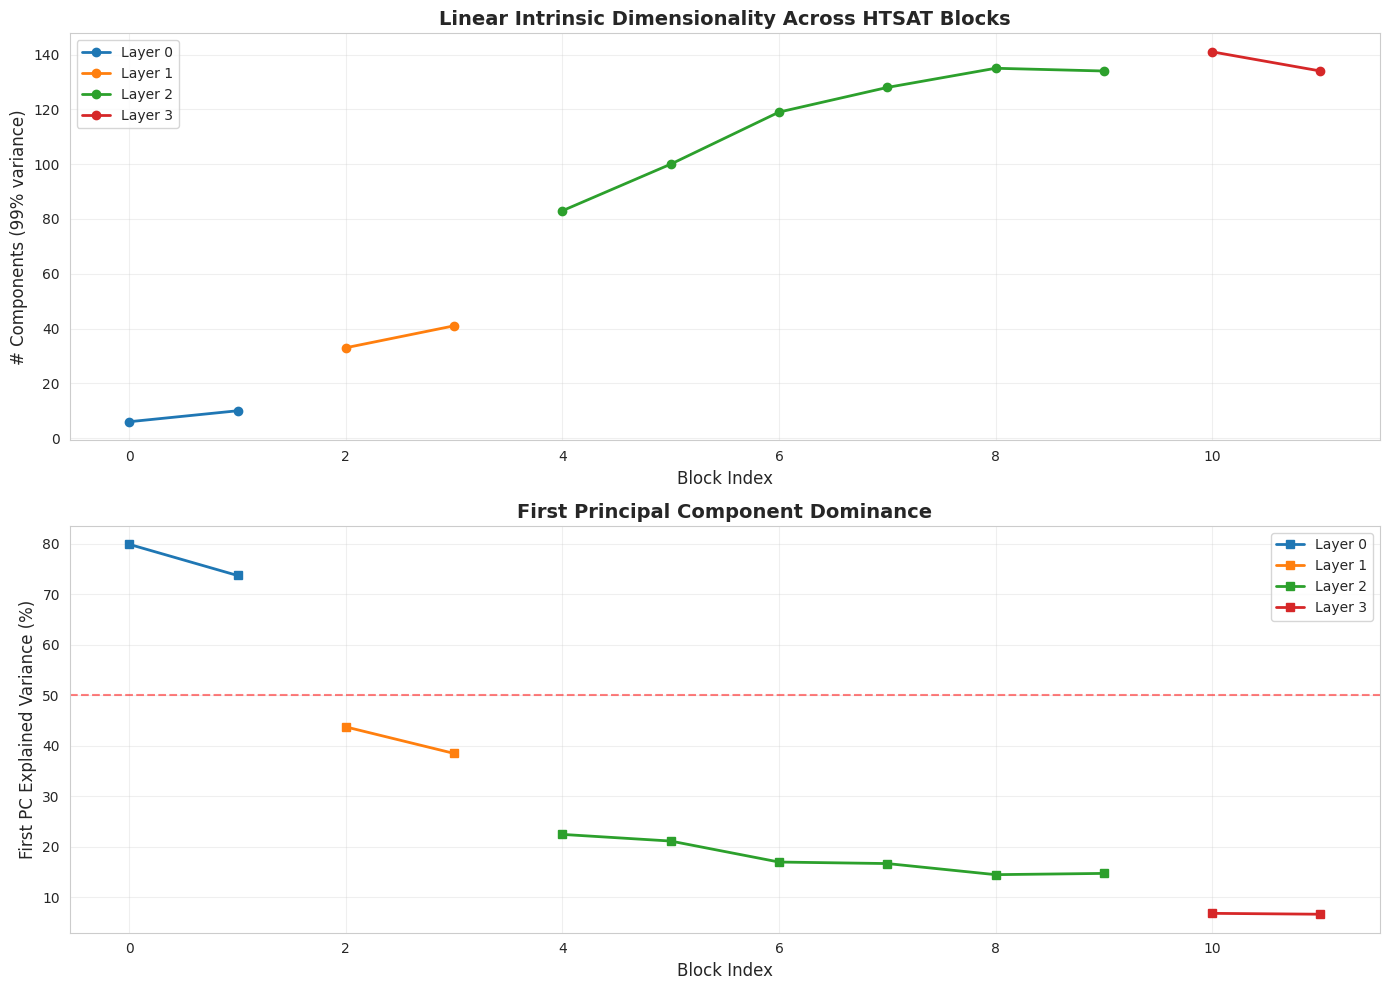


📊 Summary Statistics:
   Mean components (99% var): 88.7
   Mean first PC variance: 29.6%
   Early layers (L0) first PC: 76.8%
   Late layers (L3) first PC: 6.7%


In [21]:
# ============================================================================
# STEP 7: Visualize Intrinsic Dimensionality
# ============================================================================
print("\n" + "="*70)
print("VISUALIZING DIMENSIONALITY ANALYSIS")
print("="*70)

# Prepare data for plotting
plot_data = []
for block_key, result in id_results.items():
    layer_idx = int(block_key.split('_')[0][1:])
    block_idx = int(block_key.split('_')[1][1:])
    
    plot_data.append({
        'block': block_key,
        'layer': layer_idx,
        'block_idx': block_idx,
        'n_components_99': result['n_components_99'],
        'evr_first_pc': result['evr_first_pc']
    })

plot_df = pd.DataFrame(plot_data)

# Plot 1: Number of components across blocks
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Subplot 1: Linear ID (components needed for 99% variance)
ax1 = axes[0]
for layer in sorted(plot_df['layer'].unique()):
    layer_data = plot_df[plot_df['layer'] == layer]
    ax1.plot(layer_data.index, layer_data['n_components_99'], 
             marker='o', label=f'Layer {layer}', linewidth=2)

ax1.set_xlabel('Block Index', fontsize=12)
ax1.set_ylabel('# Components (99% variance)', fontsize=12)
ax1.set_title('Linear Intrinsic Dimensionality Across HTSAT Blocks', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Subplot 2: First PC Explained Variance Ratio
ax2 = axes[1]
for layer in sorted(plot_df['layer'].unique()):
    layer_data = plot_df[plot_df['layer'] == layer]
    ax2.plot(layer_data.index, layer_data['evr_first_pc'] * 100, 
             marker='s', label=f'Layer {layer}', linewidth=2)

ax2.set_xlabel('Block Index', fontsize=12)
ax2.set_ylabel('First PC Explained Variance (%)', fontsize=12)
ax2.set_title('First Principal Component Dominance', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=50, color='r', linestyle='--', alpha=0.5, label='50% threshold')

plt.tight_layout()
plt.savefig('dimensionality_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Summary Statistics:")
print(f"   Mean components (99% var): {plot_df['n_components_99'].mean():.1f}")
print(f"   Mean first PC variance: {plot_df['evr_first_pc'].mean()*100:.1f}%")
print(f"   Early layers (L0) first PC: {plot_df[plot_df['layer']==0]['evr_first_pc'].mean()*100:.1f}%")
print(f"   Late layers (L{plot_df['layer'].max()}) first PC: {plot_df[plot_df['layer']==plot_df['layer'].max()]['evr_first_pc'].mean()*100:.1f}%")

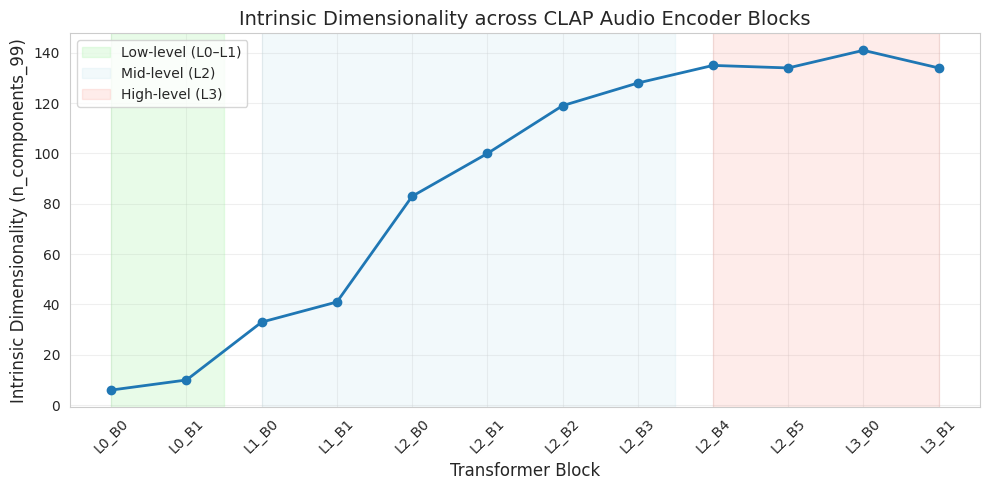

In [22]:
# Estrai i dati in ordine di layer
layer_keys = sorted(id_results.keys())
dims = [id_results[k]['n_components_99'] for k in layer_keys]

# Assegna un indice numerico ai layer
x = np.arange(len(layer_keys))

# Crea il grafico
plt.figure(figsize=(10, 5))
plt.plot(x, dims, marker='o', linewidth=2)
plt.xticks(x, layer_keys, rotation=45)
plt.xlabel("Transformer Block", fontsize=12)
plt.ylabel("Intrinsic Dimensionality (n_components_99)", fontsize=12)
plt.title("Intrinsic Dimensionality across CLAP Audio Encoder Blocks", fontsize=14)
plt.grid(True, alpha=0.3)

# Evidenzia i layer iniziali / medi / finali
plt.axvspan(0, 1.5, color='lightgreen', alpha=0.2, label='Low-level (L0–L1)')
plt.axvspan(2, 7.5, color='lightblue', alpha=0.15, label='Mid-level (L2)')
plt.axvspan(8, 11, color='salmon', alpha=0.15, label='High-level (L3)')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
# ============================================================
# STEP 8: Analyze Head Specialization with Text Prompts (fixed)
# ============================================================

print("\n" + "="*70)
print("ANALYZING HEAD SPECIALIZATION (FIXED WITH PROJECTION)")
print("="*70)

# Get text embeddings for all class labels (these are already in d_proj space)
text_embeddings = wrapper.get_text_embeddings(text_labels)  # torch.Tensor [N_classes, d_proj]

# Rendo ogni embedding testuale di lunghezza 1, 
# così quando lo confronto con un embedding audio, 
# sto misurando quanto puntano nella stessa direzione semantica, non quanto sono lunghi.
text_embeddings = text_embeddings / (text_embeddings.norm(dim=-1, keepdim=True) + 1e-8)

print(f"\n📝 Text embeddings shape: {text_embeddings.shape} (d_proj={text_embeddings.shape[1]})")


ANALYZING HEAD SPECIALIZATION (FIXED WITH PROJECTION)

📝 Text embeddings shape: torch.Size([50, 1024]) (d_proj=1024)


In [24]:
# Get all block keys (e.g. L0_B0, L0_B1, ..., L3_B1)
all_blocks = sorted(head_outputs.keys())
print(f"\n🎯 Analyzing {len(all_blocks)} blocks across all layers...")


🎯 Analyzing 12 blocks across all layers...


In [25]:
all_blocks

['L0_B0',
 'L0_B1',
 'L1_B0',
 'L1_B1',
 'L2_B0',
 'L2_B1',
 'L2_B2',
 'L2_B3',
 'L2_B4',
 'L2_B5',
 'L3_B0',
 'L3_B1']

In [26]:
# Determine device for projection (if exists) and text embeddings
proj_device = torch.device('cpu')
text_embeddings_proj_device = text_embeddings.to(proj_device)

In [27]:
torch.cat(head_outputs['L3_B0'], dim=0).mean(dim=1).shape

torch.Size([200, 768])

In [28]:
pca_objects['L3_B1'].components_[0].shape

(768,)

In [30]:
specialization_scores = {}

# Per ogni blocco (di tutti i layer)
for block_key in tqdm(all_blocks, desc="Computing specialization"):

    # Get representations from block
    representations = head_outputs[block_key]  # list of tensors [B, N, C_in]

    # Stack and pool
    stacked = torch.cat(representations, dim=0)  # [total_samples, N, C_in]
    pooled = stacked.mean(dim=1)                 # [total_samples, C_in]

    # Get first PC direction (from sklearn PCA)
    pca = pca_objects[block_key]
    pc1_direction = torch.from_numpy(pca.components_[0]).float().to(pooled.device)  # [C_in]

    # Project representations onto PC1 scalar
    pc1_projections = pooled @ pc1_direction  # [total_samples]

    # Reconstruct PC1-based vector in original feature space
    pc1_repr = pc1_projections.unsqueeze(1) * pc1_direction.unsqueeze(0)  # [total_samples, C_in]

    # Verifica la dimensione di input del projection layer
    proj_in_dim = wrapper.clap.audio_encoder.projection.linear1.in_features

    # Apply CLAP projection to d_proj space
    if pc1_repr.shape[1] == proj_in_dim:
        # Solo se la dimensione è compatibile, applichiamo la proiezione CLAP
        try:
            pc1_proj = wrapper.project_audio_representation(pc1_repr)
        except Exception:
            proj_layer = wrapper.clap.audio_encoder.projection
            device = next(proj_layer.parameters()).device
            pc1_proj = proj_layer(pc1_repr.to(device))
    else:
        # Altrimenti, usiamo direttamente il vettore PC1 (già normalizzato)
        pc1_proj = pc1_repr
    # Normalize projected vectors
    pc1_proj = pc1_proj / (pc1_proj.norm(dim=-1, keepdim=True) + 1e-8)

    # Compute similarity (audio PC1 ↔ text embeddings)
    text_embs = text_embeddings_proj_device  # [N_classes, d_proj]
    # Allinea dimensioni se diverse
    if pc1_proj.shape[1] != text_embs.shape[1]:
        adapter = torch.nn.Linear(text_embs.shape[1], pc1_proj.shape[1], bias=False).to(pc1_proj.device)
        text_embs = adapter(text_embs)
    similarity = pc1_proj @ text_embs.T      # [N_samples, N_classes]
    similarity_np = similarity.cpu().detach().numpy()

    # Compute mean similarity per class
    class_specific_sim = []
    for class_idx in range(len(dataset.classes)):
        class_mask = np.array(all_labels) == class_idx
        if class_mask.sum() > 0:
            class_sim = similarity_np[class_mask, class_idx].mean()
            class_specific_sim.append(float(class_sim))
        else:
            class_specific_sim.append(0.0)

    specialization_scores[block_key] = {
        'class_similarities': class_specific_sim,
        'mean_specialization': float(np.mean(class_specific_sim)),
        'max_specialization': float(np.max(class_specific_sim)),
        'best_class_idx': int(np.argmax(class_specific_sim))
    }

print(f"\n✅ Specialization computed for {len(specialization_scores)} blocks")

Computing specialization:   0%|          | 0/12 [00:00<?, ?it/s]


✅ Specialization computed for 12 blocks


In [31]:
text_embeddings.shape

torch.Size([50, 1024])


CREATING SPECIALIZATION HEATMAPS (ONE PER LAYER)


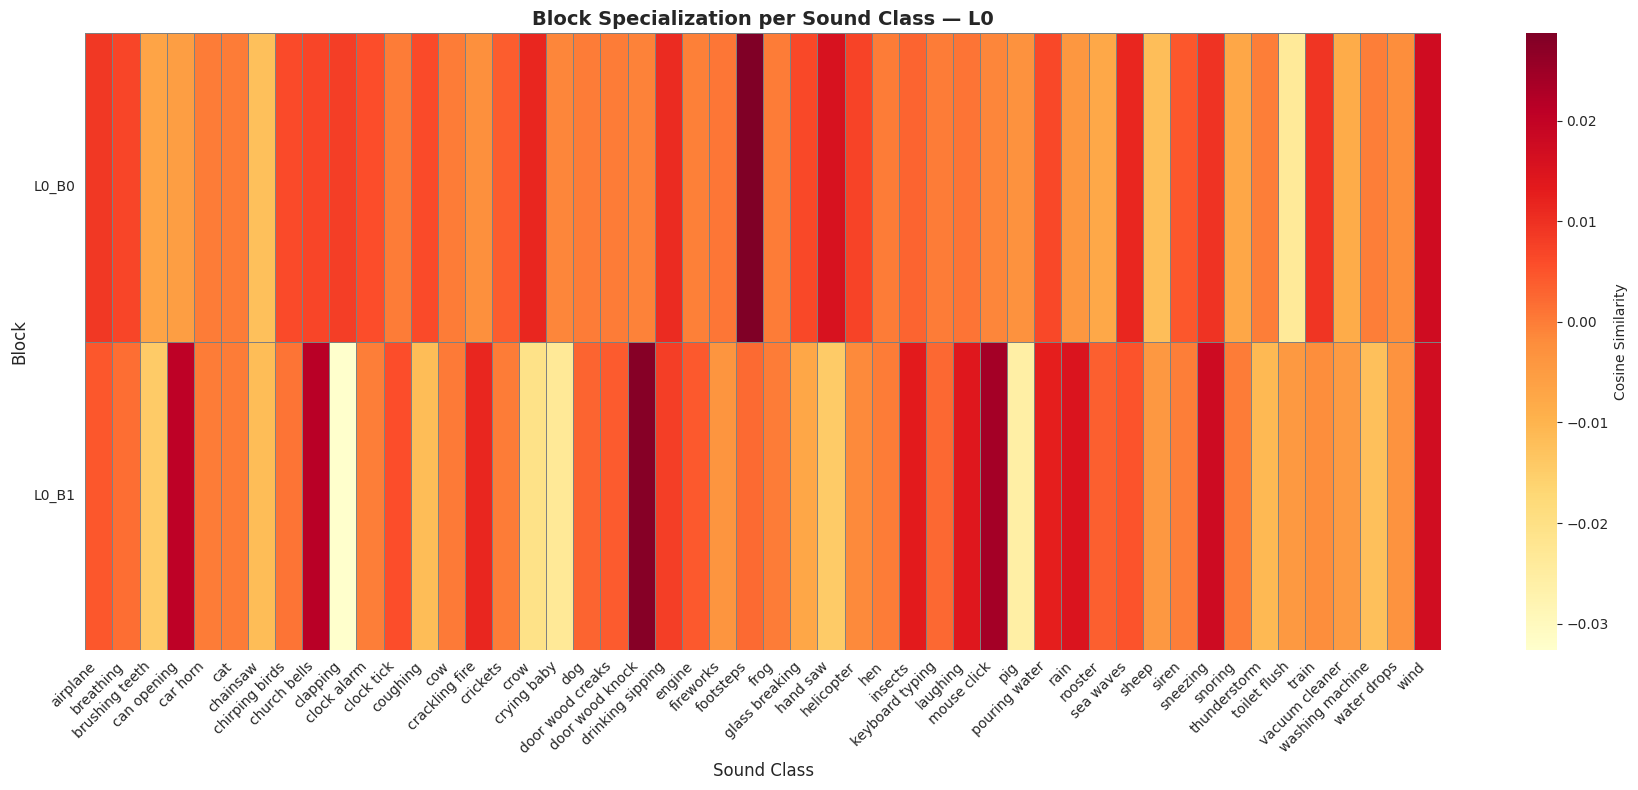

✅ Heatmap saved for L0


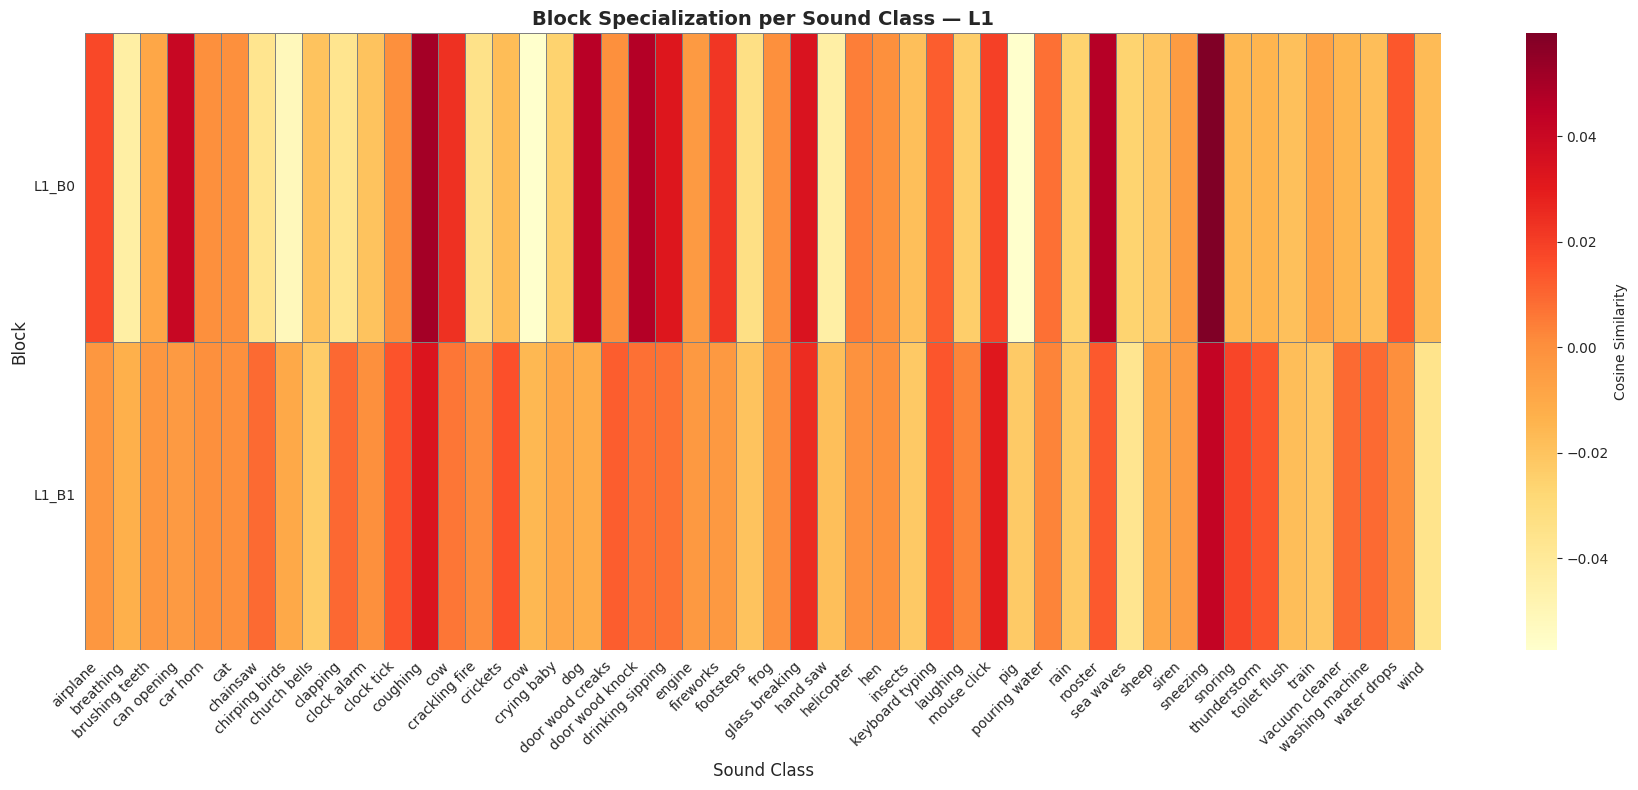

✅ Heatmap saved for L1


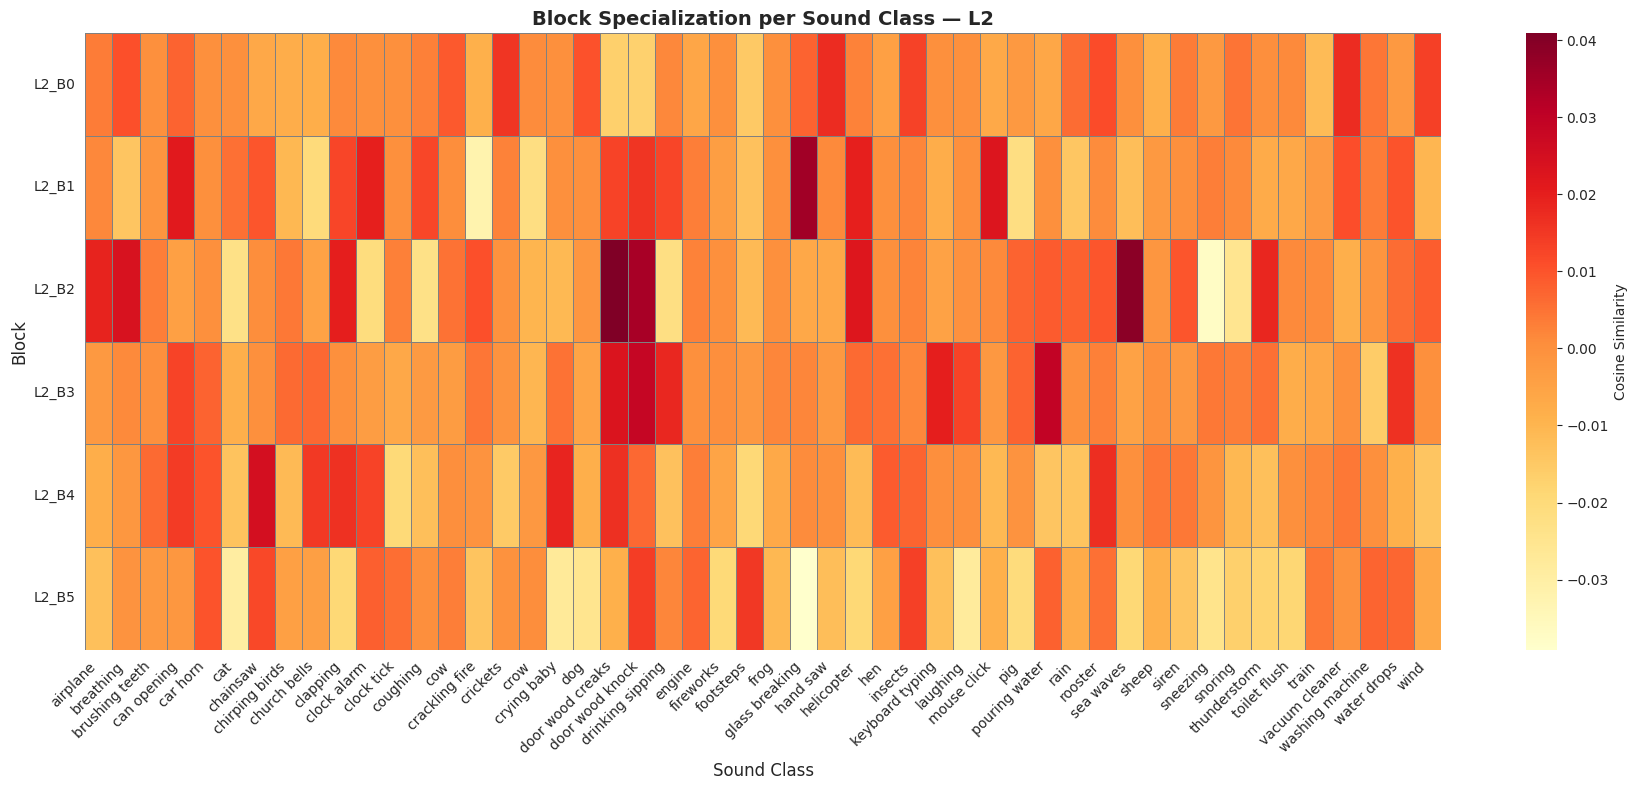

✅ Heatmap saved for L2


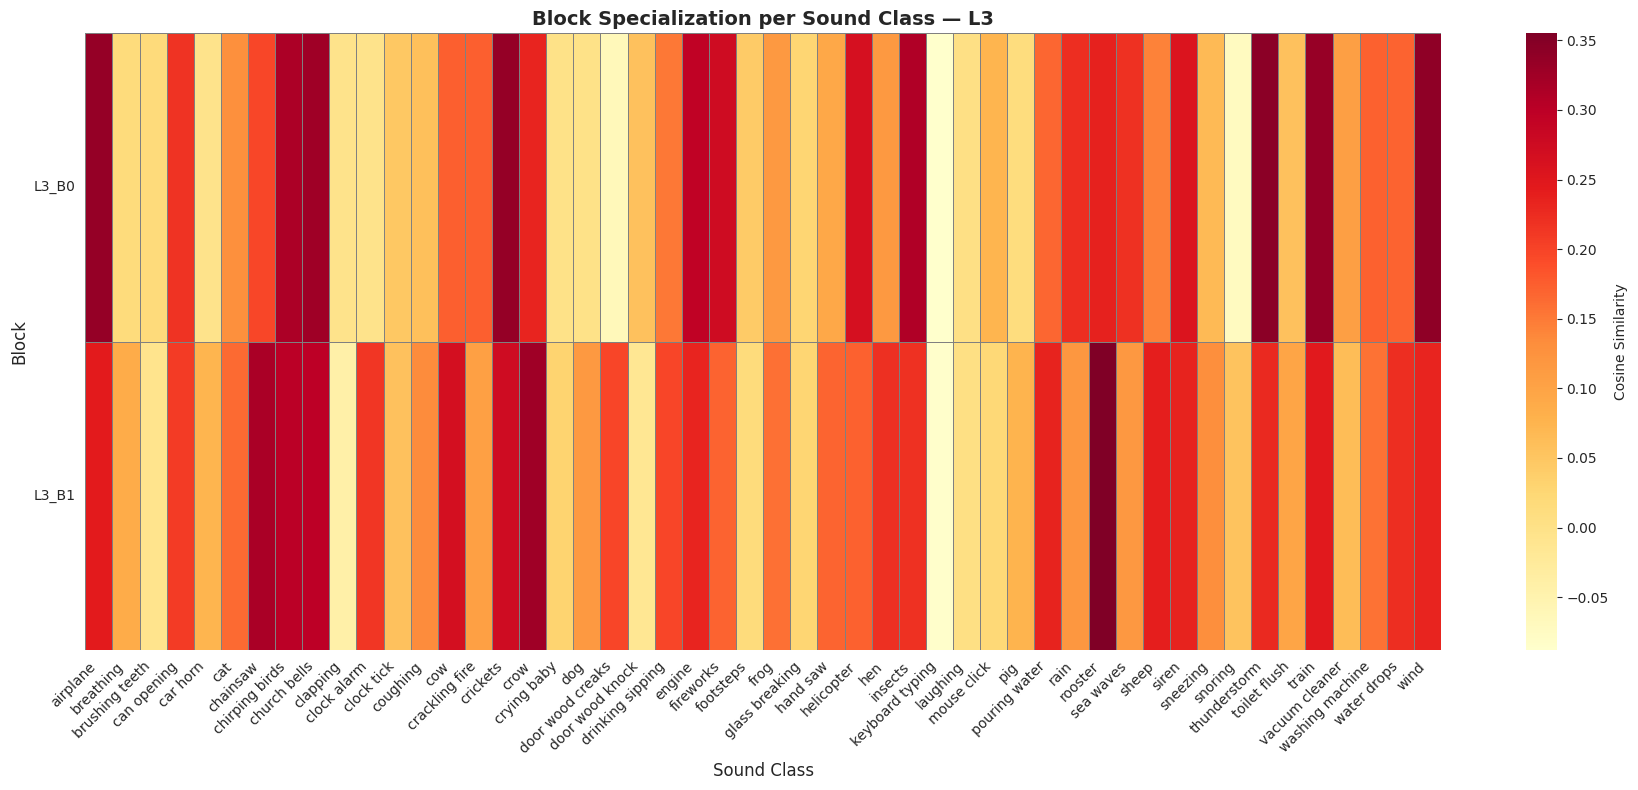

✅ Heatmap saved for L3


In [34]:
print("\n" + "="*70)
print("CREATING SPECIALIZATION HEATMAPS (ONE PER LAYER)")
print("="*70)

# Raggruppa i blocchi per layer (es. 'L0', 'L1', ...)
layer_to_blocks = {}
for block_key in sorted(specialization_scores.keys()):
    layer_name = block_key.split('_')[0]  # es. 'L0' da 'L0_B1'
    layer_to_blocks.setdefault(layer_name, []).append(block_key)

# Genera una heatmap per ogni layer
for layer_name, block_keys in layer_to_blocks.items():
    spec_matrix = []
    block_names = []

    for block_key in block_keys:
        spec_matrix.append(specialization_scores[block_key]['class_similarities'])
        block_names.append(block_key)

    spec_matrix = np.array(spec_matrix)

    plt.figure(figsize=(18, 8))
    sns.heatmap(
        spec_matrix,
        xticklabels=dataset.classes,
        yticklabels=block_names,
        cmap='YlOrRd',
        cbar_kws={'label': 'Cosine Similarity'},
        linewidths=0.5,
        linecolor='gray'
    )

    plt.title(f'Block Specialization per Sound Class — {layer_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Sound Class', fontsize=12)
    plt.ylabel('Block', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'specialization_heatmap_{layer_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✅ Heatmap saved for {layer_name}")

In [35]:
print("\n" + "="*80)
print("SPECIALIZATION SCORES PER LAYER E BLOCCO")
print("="*80)

# Raggruppiamo per layer come prima
layer_to_blocks = {}
for block_key in sorted(specialization_scores.keys()):
    layer_name = block_key.split('_')[0]  # es. 'L0'
    layer_to_blocks.setdefault(layer_name, []).append(block_key)

# Per ogni layer
for layer_name, block_keys in layer_to_blocks.items():
    print(f"\n{'#'*70}")
    print(f"📘 {layer_name} — Specialization Details")
    print(f"{'#'*70}")

    # Per ogni blocco nel layer
    for block_key in block_keys:
        block_data = specialization_scores[block_key]
        class_sims = block_data['class_similarities']
        mean_spec = block_data['mean_specialization']
        max_spec = block_data['max_specialization']
        best_idx = block_data['best_class_idx']
        best_class = dataset.classes[best_idx] if best_idx < len(dataset.classes) else "N/A"

        print(f"\n🧩 {block_key}")
        print(f"   • Mean specialization: {mean_spec:.4f}")
        print(f"   • Max specialization:  {max_spec:.4f} ({best_class})")
        print("   • Per-class similarities:")
        
        # Stampa tutte le classi con i valori allineati
        for cls, val in zip(dataset.classes, class_sims):
            print(f"     - {cls:<25s} {val:.4f}")
    
    print(f"\n{'-'*80}\n")

print("\n✅ Completed printing all specialization details.")



SPECIALIZATION SCORES PER LAYER E BLOCCO

######################################################################
📘 L0 — Specialization Details
######################################################################

🧩 L0_B0
   • Mean specialization: 0.0020
   • Max specialization:  0.0287 (footsteps)
   • Per-class similarities:
     - airplane                  0.0090
     - breathing                 0.0069
     - brushing teeth            -0.0066
     - can opening               -0.0054
     - car horn                  0.0000
     - cat                       0.0000
     - chainsaw                  -0.0125
     - chirping birds            0.0063
     - church bells              0.0071
     - clapping                  0.0080
     - clock alarm               0.0059
     - clock tick                0.0000
     - coughing                  0.0064
     - cow                       -0.0000
     - crackling fire            -0.0026
     - crickets                  0.0040
     - crow             